In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras import models, Model, mixed_precision
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080 Ti, compute capability 8.6


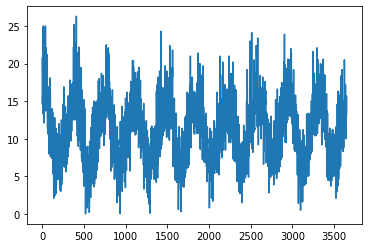

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv')
temps_series = df['Temp'].to_numpy()
split_point = round(len(temps_series)*0.8)
train = temps_series[:split_point]
val = temps_series[split_point:]

window_size = 365
batch_size = 128
shuffle_buffer_size = len(temps_series)


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)  # expand from 1D to 2D for LSTM
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(-1)
    return dataset


train_ds = windowed_dataset(train, window_size, batch_size, shuffle_buffer_size)
val_ds = windowed_dataset(val, window_size, batch_size, shuffle_buffer_size)
plt.plot(temps_series)
plt.show()

In [3]:
xInput = Input((window_size, 1))
x = Conv1D(filters=32, kernel_size=3, activation='relu')(xInput)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = Dropout(0.2)(x)
x = Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(32, return_sequences=True))(x)
x = Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(64, return_sequences=True))(x)
x = Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(128, return_sequences=True))(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
xOut = Dense(1)(x)
model = Model(inputs=xInput, outputs=xOut)

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['mae'])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)
history = model.fit(train_ds, epochs=200, validation_data=val_ds, verbose=1, use_multiprocessing=True)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 365, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 363, 32)           128       
                                                                 
 conv1d_1 (Conv1D)           (None, 361, 64)           6208      
                                                                 
 dropout (Dropout)           (None, 361, 64)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 361, 64)          25088     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 361, 128)         66560     
 nal)                                                       

In [4]:
forecast = []
results = []
for time in range(len(temps_series) - window_size):
    forecast.append(model.predict(temps_series[time:time + window_size][np.newaxis]))  # np.newaxis only work with numpy array, NOT lists!

forecast = forecast[split_point - window_size:]
results = np.array(forecast)[:, 0, 0]


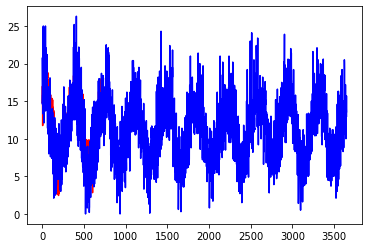

In [6]:
plt.plot(results, 'r')
plt.plot(temps_series, 'b')
plt.show()